In [1]:
%load_ext autoreload 
%autoreload 2

In [2]:
import glob
import numpy as np
import matplotlib.pyplot as plt
from ekfplot import plot as ek
from ekfplot import colors as ec
import pandas as pd
from astropy import units as u
from astropy import cosmology 
from carpenter import emission, conventions
from ekfplot import colorlists
from ekfphys import calibrations
import tqdm

cosmo = cosmology.FlatLambdaCDM(70.,0.3)

In [3]:
import os

In [4]:
catalog = pd.read_parquet('../../carpenter/data/MDR1_catalogs/mdr1_n708maglt26_and_pzgteq0p1.parquet')
catalog = catalog.set_index('objectId_Merian')
catalog.index = [ f'M{sidx}' for sidx in catalog.index ]

# Estimate AV
av, u_av = emission.estimate_av(catalog)
catalog['AV'] = av
catalog['u_AV'] = u_av

# Compute emission corrections
emission_corrections = emission.compute_emissioncorrections(catalog, logmstar_key='logmass_gaap1p0')
ancline_correction, ge_correction, extinction_correction, catalog_apercorr = emission_corrections


catalog['n708_correction'] = ancline_correction * ge_correction[:,2] * extinction_correction[0,:,2] 
catalog['n540_correction'] = ge_correction[:,3] * extinction_correction[0,:,3] 

/home/kadofong/.conda/envs/merenv/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


Computed aperture correction in 0.0 seconds.
Computed line contamination correction in 0.0 seconds.
Loading precomputed Galactic extinction map...
Interpolated Galactic extinction values from map.


/home/kadofong/.conda/envs/merenv/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/kadofong/merian/carpenter/src/carpenter/emission.py:338: RuntimeWarning: divide by zero encountered in reciprocal
  emission_correction = correct_NIISII(redshift_values, aperture_corrected_logmass)**-1


Computed Galactic extinction correction in 0.9 seconds.
Computed internal extinction corrections in 0.8 seconds.


In [5]:
band = 'n708'
sourcedir = 'MDR1_mcmasses'
files = glob.glob(f'../local_data/pieridae_output/{sourcedir}/*/*_{band}_mcmc_results.npz')

In [ ]:
files = glob.glob(f'../local_data/pieridae_output/{sourcedir}/*/*_{band}_mcmc_results.npz')
mcdf = []
for ff in tqdm.tqdm(files):
    res = np.load(ff)
    targetid = res['target']
    #targetid = conventions.merianobjectname_to_catalogname(target, catalog)
    conversion = 10.**(-0.4*(27-31.4))
    fluxes = emission.excess_to_lineflux(res['mle_fluxes']*conversion*u.nJy, 'n708')
    df = pd.DataFrame(fluxes, columns=['lineflux'])
    df['label'] = np.arange(fluxes.size)
    df['merianid'] = targetid
    df = df.set_index(['merianid','label'])
    mcdf.append(df)

mcdf = pd.concat(mcdf)

mcdf['lineflux_corrected'] = mcdf['lineflux'] * catalog.reindex(mcdf.index.get_level_values(0))['n708_correction'].values

In [85]:
files = glob.glob(f'../local_data/pieridae_output/{sourcedir}/*/*_{band}_mcmc_region_photometry.csv')
ofiles = len(files)
#files = files + glob.glob(f'../local_data/pieridae_output/MDR1_starbursts_specz/*/*_{band}_mcmc_region_photometry.csv')
ovldf = []
for idx in tqdm.tqdm(range(ofiles)):
    file = files[idx]
    df = pd.read_csv(file)
    target = df.iloc[0]['target']
    targetid = conventions.merianobjectname_to_catalogname(target, catalog)
    df['merianid'] = targetid
    if idx >= ofiles:
        df['sample'] = 'starburst'
    else:
        df['sample'] = 'mcmasses'
    df = df.set_index(['merianid','label'])
    
    ovldf.append(df)
ovldf = pd.concat(ovldf)

100%|██████████| 2330/2330 [00:36<00:00, 63.00it/s]


In [86]:
ovldf = ovldf.loc[~ovldf.index.duplicated()]

In [87]:
mains = ovldf.loc[ovldf.index.get_level_values(1) == -1]
mains = mains.set_index(mains.index.get_level_values(0))

catmag = -2.5*np.log10(catalog.loc[mains.index,'r_cModelFlux_Merian']*1e-9/3631.)
truemag = -2.5*np.log10(ovldf.loc[ovldf.index.get_level_values(1) == -2, 'kron_flux']) + 31.4
logmass_adjusted = catalog.loc[mains.index, 'logmass'] + -0.4*(truemag-catmag)
logmass_adjusted.index = logmass_adjusted.index.get_level_values(0)

/home/kadofong/.conda/envs/merenv/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [88]:
ovldf = ovldf.reindex(logmass_adjusted.loc[logmass_adjusted<9.6].index, level=0)

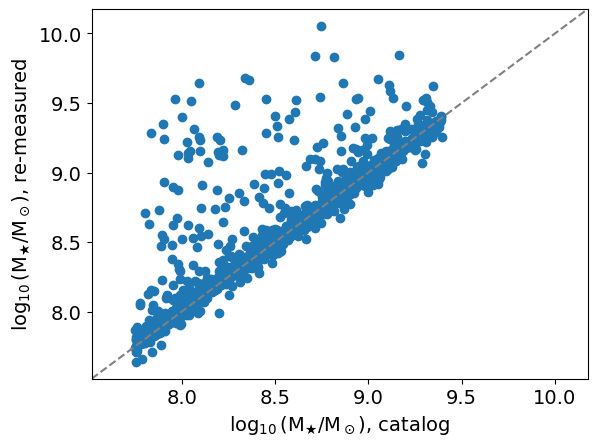

In [89]:
plt.scatter (
    catalog.loc[mains.index,'logmass'],
    logmass_adjusted
)
plt.xlabel(r'$\log_{10}(\rm M_\bigstar/M_\odot)$, catalog')
plt.ylabel(r'$\log_{10}(\rm M_\bigstar/M_\odot)$, re-measured')
ek.oneone()

In [90]:
mergers = pd.concat([
    #pd.read_csv('../local_data/pieridae_output/MDR1_mcmasses/classifications.csv', index_col=0),
    pd.read_csv('../local_data/pieridae_output/MDR1_starbursts_specz/classifications.csv', index_col=0),
])
mergers = mergers.loc[~mergers.index.duplicated()]

In [91]:
brightest_ids = mcdf.loc[mcdf.index.get_level_values(1) > 0].groupby(level=0)['lineflux'].idxmax().dropna()
brightest = mcdf.loc[brightest_ids]
brightest = brightest.set_index(brightest.index.get_level_values(0))
#brightest['lineflux'] *= catalog.reindex(brightest.index.get_level_values(0))['n708_correction'].values

brightest_ids = ovldf.loc[ovldf.index.get_level_values(1) > 0].groupby(level=0)['lineflux_corrected'].idxmax().dropna()
brightest_reg = ovldf.loc[brightest_ids]
brightest_reg = brightest_reg.set_index(brightest_reg.index.get_level_values(0))
fluxes = emission.excess_to_lineflux(brightest_reg['kron_flux'].values*conversion*u.nJy, 'n708')
brightest_reg['lineflux'] = fluxes

#lt.scatter(
#   ovldf.loc[mcdf.index.get_level_values(0)].loc[-1, 'lineflux_corrected'],
#   (mcdf.loc[:,'lineflux']*catalog.reindex(mcdf.index.get_level_values(0))['n708_correction'].values).loc[target]

In [92]:
def fn(x):
    if isinstance(x, str):
        ft = float(x.split()[0])
    else:
        ft = float(x)
    if ft>0.:
        return ft
    else:
        return np.nan
        
        
ovldf['mcmc_model_lineflux'] = ovldf.apply(lambda x: fn(x['mcmc_model_lineflux']), axis=1)

Text(0, 0.5, 'H$\\alpha$ flux, MCMC-matched [erg/s/cm$^{2}$]')

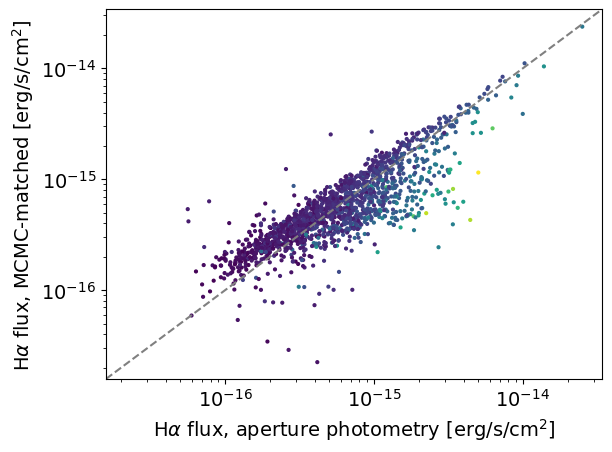

In [130]:
plt.scatter(
    ovldf['lineflux_corrected'],
    ovldf['mcmc_model_lineflux'],
    c=ovldf['semimajor_sigma'],
    s=4
)
ek.loglog()
ek.oneone()
#plt.ylim(0., 2.)
plt.xlabel(r'H$\alpha$ flux, aperture photometry [erg/s/cm$^{2}$]')
plt.ylabel(r'H$\alpha$ flux, MCMC-matched [erg/s/cm$^{2}$]')

/home/kadofong/packages/ekfutils/ekfplot/ekfplot/plot.py:342: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  im = ax.scatter( x,y,c=c, **kwargs)
/home/kadofong/packages/ekfutils/ekfplot/ekfplot/plot.py:342: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
  im = ax.scatter( x,y,c=c, **kwargs)
/home/kadofong/packages/ekfutils/ekfstats/ekfstats/sampling.py:659: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  xpull = x[choice]


(1e+38, 1e+42)

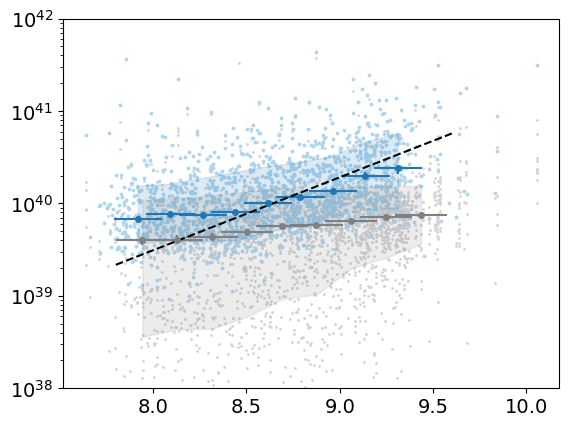

In [143]:
tot_linefluxes = mcdf.groupby(level=0).sum()

ek.scatter(
    logmass_adjusted.reindex(tot_linefluxes.index).values,
    tot_linefluxes['lineflux_corrected'].values.flatten()*4.*np.pi*cosmo.luminosity_distance(0.08).to(u.cm).value**2,
    s=3,
    c=ec.ColorBase('tab:blue').modulate(0.4).base
)
ek.running_quantile(
    logmass_adjusted.reindex(tot_linefluxes.index).values,
    tot_linefluxes['lineflux_corrected'].values.flatten()*4.*np.pi*cosmo.luminosity_distance(0.08).to(u.cm).value**2,
    bins=10,
    color='C0',
    erronqt=True,
    std_format='fill_between'
)

ek.scatter(
    logmass_adjusted.reindex(mcdf.index.get_level_values(0)),
    mcdf['lineflux_corrected']*4.*np.pi*cosmo.luminosity_distance(0.08).to(u.cm)**2,
    s=1,
    color='lightgrey',
    zorder=0
)
ek.running_quantile(
    logmass_adjusted.reindex(mcdf.index.get_level_values(0)),
    mcdf['lineflux_corrected'].values.flatten()*4.*np.pi*cosmo.luminosity_distance(0.08).to(u.cm)**2,
    bins=10,
    color='grey',
    erronqt=True
)

z = 0.08
alpha = -0.13*z + 0.8
sfr0 = 1.24*z - 1.47
sigma = 0.22*z + 0.38
ms = np.linspace(7.8,9.6,10)
plt.plot(
    ms,
    calibrations.SFR2LHa(10.**(alpha * (ms - 8.5) + sfr0)), # + 1.5*sigma
    color='k',
    ls='--'
)

plt.yscale('log')
plt.ylim(1e38,1e42)

In [ ]:
brightest_ids = mcdf.loc[mcdf.index.get_level_values(1) > 0].groupby(level=0)['lineflux'].idxmax().dropna()
brightest = mcdf.loc[brightest_ids]
brightest = brightest.set_index(brightest.index.get_level_values(0))

#ancline_correction, ge_correction, extinction_correction, catalog_apercorr


plt.scatter(
    logmass_adjusted.loc[mcdf.index.get_level_values(0)],
    mcdf['lineflux']*catalog.reindex(mcdf.index.get_level_values(0))['n708_correction'].values,
    c='lightgrey'    
) 

plt.scatter(
    logmass_adjusted.loc[brightest.index],
    brightest['lineflux']*catalog.reindex(brightest.index)['n708_correction'],
    c='C0'
    
) 

plt.xlim(7.7, 9.6)
plt.ylim(1e-17, 4e-14)
plt.yscale('log')
plt.legend( fontsize=10)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


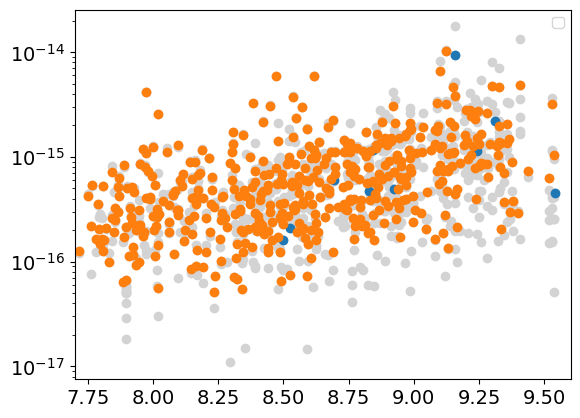

In [233]:

brightest_ids = ovldf.loc[ovldf.index.get_level_values(1) > 0].groupby(level=0)['lineflux_corrected'].idxmax().dropna()
brightest = ovldf.loc[brightest_ids]
brightest = brightest.set_index(brightest.index.get_level_values(0)).reindex(mains.index)



if False:
    plt.scatter(
        logmass_adjusted.loc[mains.index.get_level_values(0)],
        mains['lineflux_corrected'],
        c='C0',
    )
else:
    plt.scatter(
        logmass_adjusted.loc[ovldf.index.get_level_values(0)],
        ovldf['lineflux_corrected'],
        c='lightgrey'
        
    ) 
    
if False:
    flags = ['single','merger','unclear','fragmentation','artifact']
    for viz in range(1,4):
        sample = mergers.query(f'classification=={viz}').index
        plt.scatter(
            logmass_adjusted.reindex(sample),
            brightest.reindex(sample)['lineflux_corrected'],
            label=flags[viz-1],
            color=f'C{viz}'
        )
else:
    for viz in ['starburst','mcmasses']:
        sample = brightest.query(f'sample=="{viz}"')
        plt.scatter(
            logmass_adjusted.loc[sample.index.get_level_values(0)],
            sample['lineflux_corrected'],
        )        
plt.xlim(7.7, 9.6)
plt.yscale('log')
plt.legend( fontsize=10)

In [213]:
ovldf.loc['M3495703706467318350']

,xcentroid,ycentroid,sky_centroid,bbox_xmin,bbox_xmax,bbox_ymin,bbox_ymax,area,semimajor_sigma,semiminor_sigma,...,kron_flux,kron_fluxerr,lineflux_corrected,band,target,mcmc_model_lineflux,mcmc_model_x,mcmc_model_y,mcmc_n_sources,sample
label,,,,,,,,,,,,,,,,,,,,,
1,48.626028,49.431394,NaN,43.0,54.0,44.0,54.0,75.0,2.961389,1.630165,...,75.672013,NaN,7.673963e-16,n708,J095425.79+023146.52,0.0,48.544977,49.368248,1,starburst
-1,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.000000,0.0,7.236178e-16,n708,J095425.79+023146.52,0.0,0.000000,0.000000,1,starburst
-2,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,...,9556.172393,0.0,0.000000e+00,r,J095425.79+023146.52,0.0,0.000000,0.000000,1,starburst


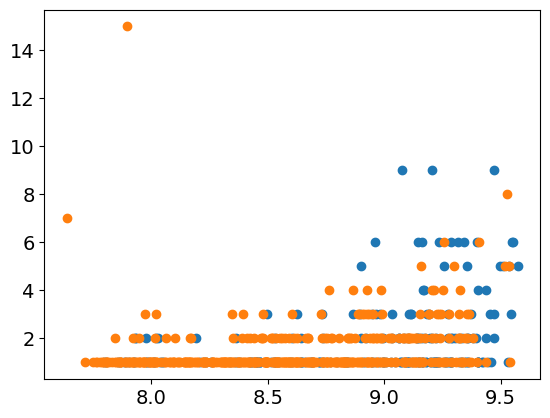

In [209]:
nsources = ovldf.groupby(level=0).count()['target']-2
for viz in ['starburst','mcmasses']:
    sample = brightest.query(f'sample=="{viz}"')
    plt.scatter(
        logmass_adjusted.loc[sample.index.get_level_values(0)],
        nsources.loc[sample.index]
    ) 

(0.0, 9.0)

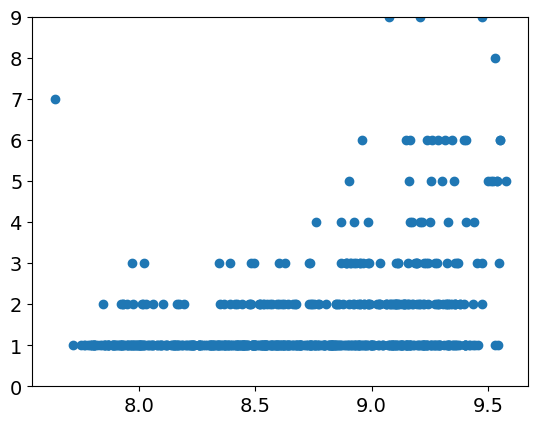

In [208]:
nsources = ovldf.groupby(level=0).count()['target']-2
ek.scatter(
    logmass_adjusted.loc[nsources.index],
    nsources,
    #bins=[np.arange(7.8,9.75,0.25),np.arange(0,10,1.)],
)
plt.ylim(0., 9.)

(<Axes: >,
 (array([134.,   0.,  39.,   0.,   0.,  19.,   0.,   4.,   0.,   0.,   7.,
           0.,  10.,   0.,   0.,   0.,   0.,   0.,   0.]),
  array([1.        , 1.39736842, 1.79473684, 2.19210526, 2.58947368,
         2.98684211, 3.38421053, 3.78157895, 4.17894737, 4.57631579,
         4.97368421, 5.37105263, 5.76842105, 6.16578947, 6.56315789,
         6.96052632, 7.35789474, 7.75526316, 8.15263158, 8.55      ]),
  <BarContainer object of 19 artists>))

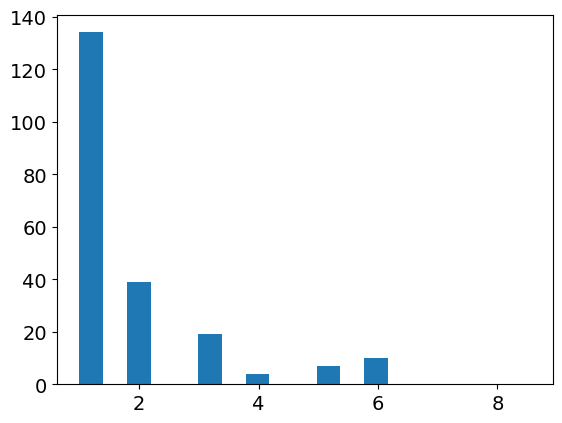

In [94]:
ek.hist(ovldf.groupby(level=0).count()['target']-2)

In [40]:
brightest['r_offset'] = np.sqrt((brightest['xcentroid'] - 50.)**2 + (brightest['ycentroid'] - 50.)**2)

In [41]:
ratio = brightest['lineflux_corrected']/mains['lineflux_corrected']
ratio = np.where(ratio>1., 1., ratio)
ratio = np.where(ratio<0., 0., ratio)


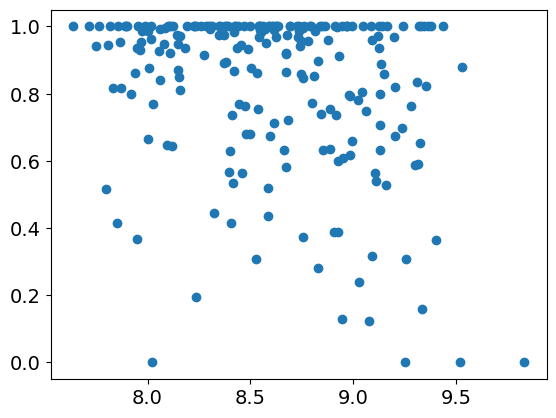

In [42]:
plt.scatter(
    logmass_adjusted.reindex(brightest.index),
    ratio,
)
#plt.yscale('log')